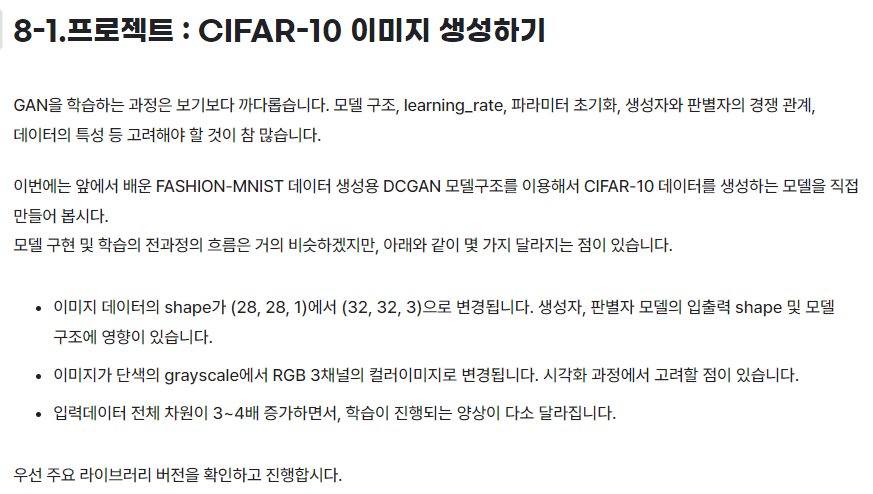

In [8]:
#라이브러리 불러오기

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print('imageio',imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


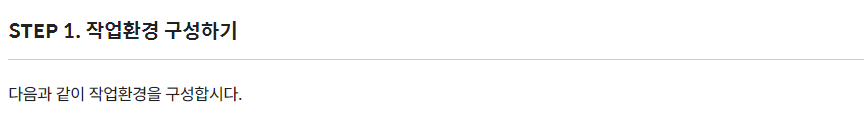

In [5]:
#작업환경 구축
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

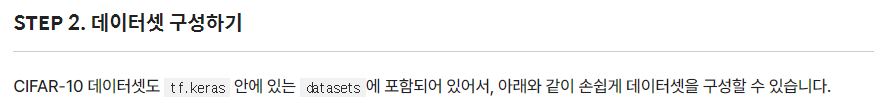

In [260]:
#데이터셋 불러오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()
#데이터셋의 양이 많기때문에 학습시 시간이 오래걸려 하나의 데이터셋만 불러옴
train_x.shape

(50000, 32, 32, 3)

In [261]:
#학습에 사용할 데이터셋(train_x의 이미지를 -1,1로 정규화)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

#train_x = (train_x-127.5)/127.5
train_x = (train_x)/255
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: 0.0


(50000, 32, 32, 3)

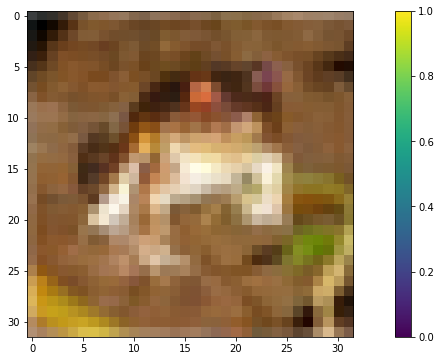

In [262]:
#학습데이터 샘플링하여 시각화
plt.imshow(train_x[0].reshape(32, 32,3))
plt.colorbar()
plt.show()

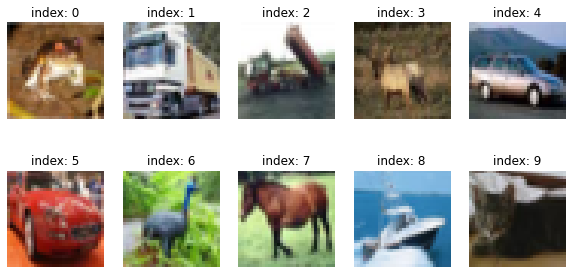

In [263]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    #plt.imshow((train_x[index] + 1) / 2) # Rescale values to [0, 1]
    plt.imshow(train_x[i].reshape(32, 32,3),cmap='Pastel2')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

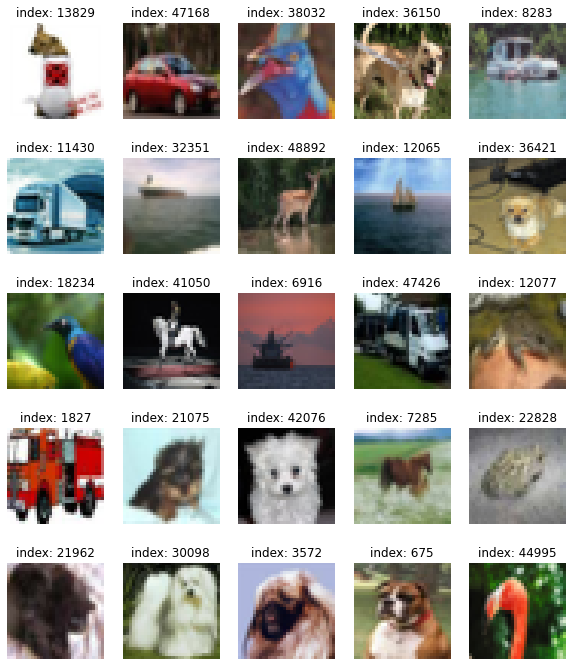

In [264]:
#데이터셋중에서 랜덤으로 샘플링하여 시각화
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, len(train_x))
    plt.imshow(train_x[random_index].reshape(32, 32,3),cmap='Pastel2')
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [265]:
#tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

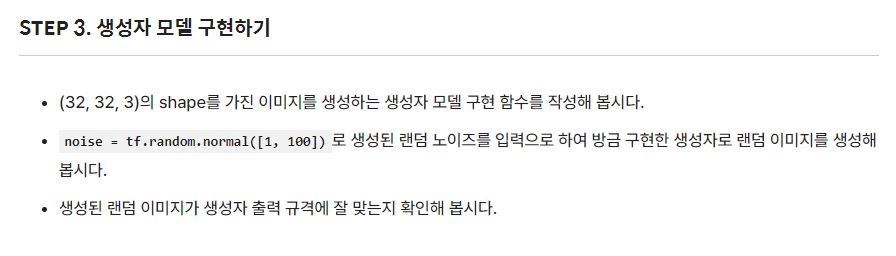

In [290]:
#생성자 모델 구현(함수화)
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())


    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='sigmoid'))

    return model

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_34 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 8, 8, 128)       

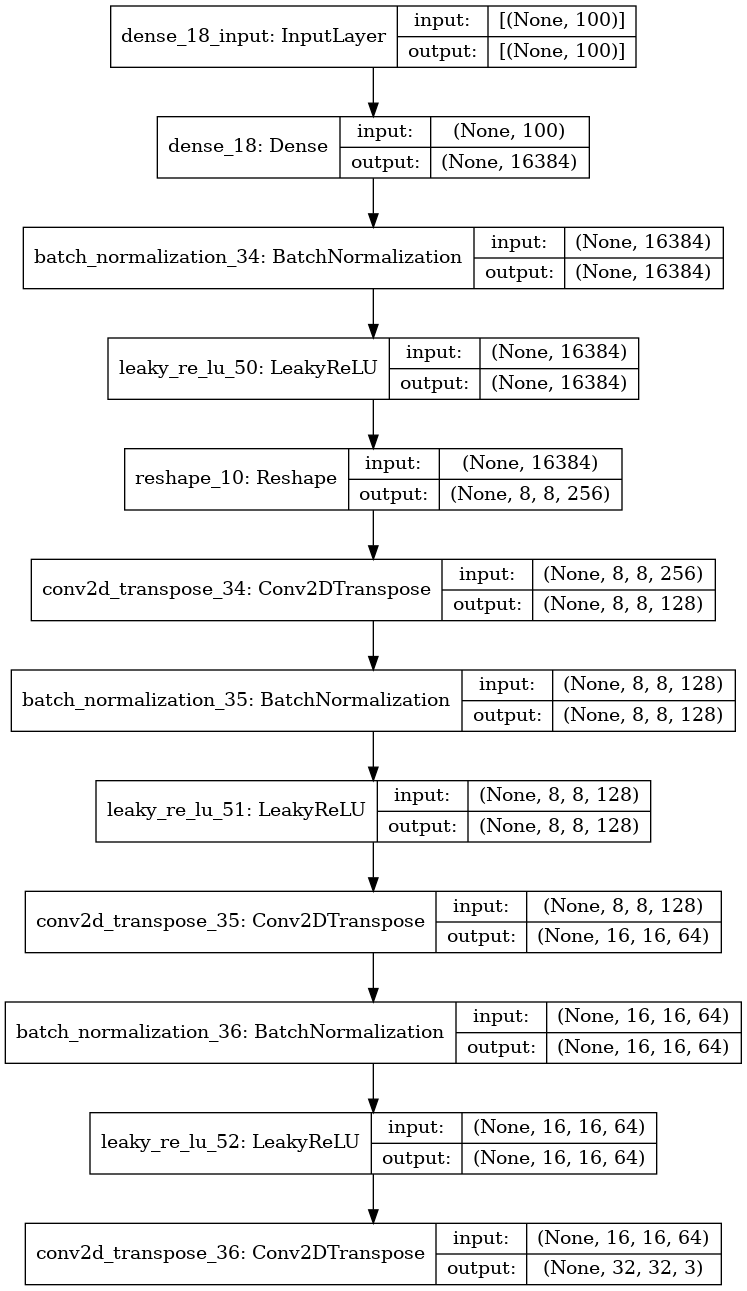

In [291]:
#make_generator_model모델구조 시각화
generator = make_generator_model()

generator.summary()

#모델구조 시각화
from tensorflow.keras import  utils
utils.plot_model(generator,show_shapes=True)

In [292]:
#noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
noise = tf.random.normal([1, 100])

In [293]:
#생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

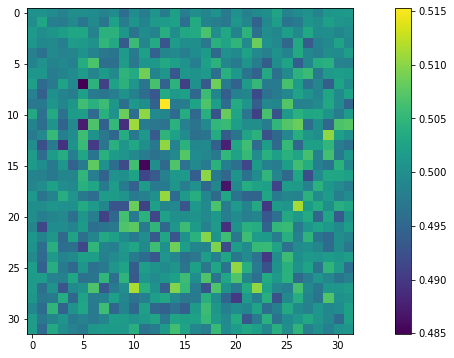

In [294]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

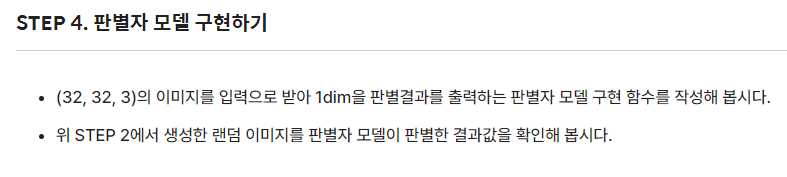

In [295]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.5을 사용
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.5을 사용
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)            

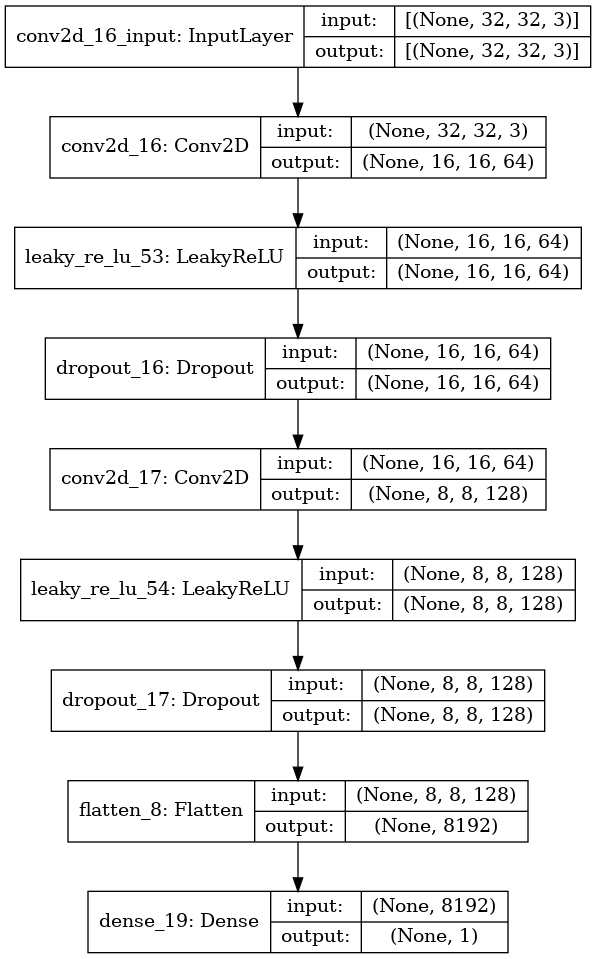

In [296]:
#make_discriminator_model모델구조 시각화
discriminator  = make_discriminator_model()

discriminator .summary()

#make_discriminator_model모델구조 시각화
from tensorflow.keras import  utils
utils.plot_model(discriminator,show_shapes=True)

In [297]:
#위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.
decision = discriminator(generated_image, training=False)
decision
#텐서플로우의 텐서형태로 출력됨(제대로 판별은 하고있는거같음)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.06230684]], dtype=float32)>

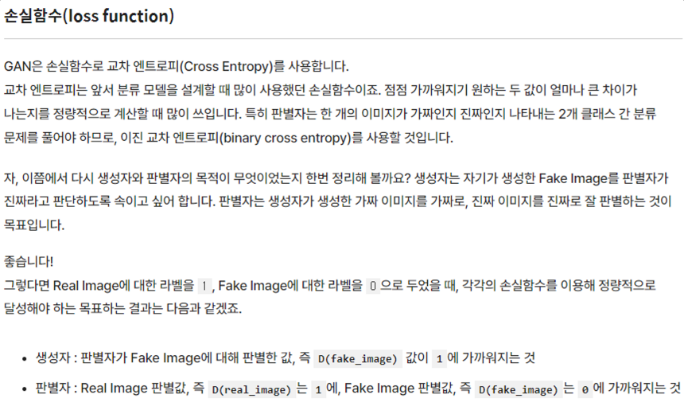

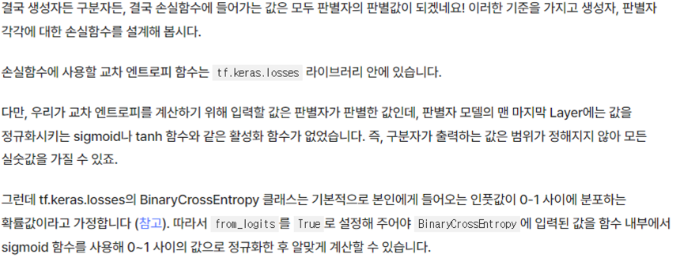

In [298]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [299]:
#두개의 네트워크를 통해 gan네트워크를 만들기때문에 각각 생성자와 판별자의 손실함수를 만들어준다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss+fake_loss
    return total_loss

In [300]:
#판별자의 이미지 판별정확도 함수구현
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 라벨스무딩을 사용하여 손실함수와 판별자의 정확도함수 다시구현

In [301]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
#라벨스무딩적용(판별자를 좀더 유연하게 속이기위해)
def discriminator_loss(real_output, fake_output, label_smoothing=0.1):
    # 진짜 이미지에 대한 라벨을 1 대신 1 - label_smoothing 값으로 설정
    smoothed_real_labels = tf.ones_like(real_output) * (1 - label_smoothing)
    # 가짜 이미지에 대한 라벨을 0 대신 label_smoothing 값으로 설정
    smoothed_fake_labels = tf.zeros_like(fake_output) + label_smoothing
    
    # 손실함수는 cross entropy를 사용
    real_loss = cross_entropy(smoothed_real_labels, real_output)
    fake_loss = cross_entropy(smoothed_fake_labels, fake_output)
    
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss
#라벨스무딩을 적용한 정확도 함수도 수정
def discriminator_accuracy(real_output, fake_output, smoothing_factor=0.1):
    # 라벨 스무딩을 고려한 경계값을 설정합니다.
    threshold = 0.5 * (1 - smoothing_factor)
    
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([threshold])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([1 - threshold])), tf.float32))
    
    return real_accuracy, fake_accuracy



## 아래 학습률 스케줄링 조정해서 다시 시도해볼예정

In [348]:
#최적화하는 optimizer설정(학습률 스케쥴링 추가시도)
# 초기 학습률과 스케줄러 설정
#총 스텝 수 = 에폭 수 x (데이터셋 크기 / 배치 크기)
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)
generator_optimizer = tf.keras.optimizers.Adam(0.00009)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [327]:
#샘플링 시드고정
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

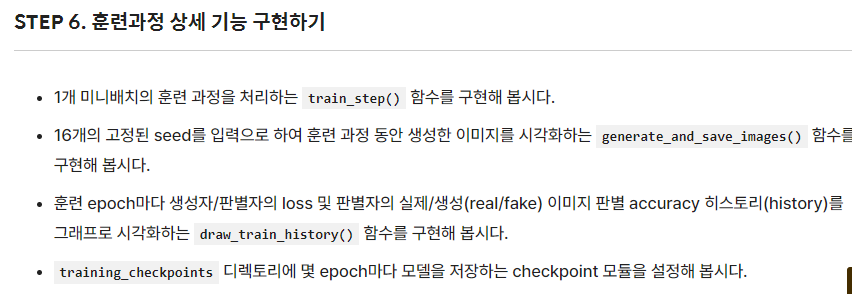

In [328]:
#훈련과정을 미니배치마다 처리하는 train_step()구현
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss =discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 아래는 판별자의 학습빈도를 생성자보다 낮추어 fake acc를 낮추는 방법시도(생성자의 학습과 판별자의 학습함수 따로구현)

In [329]:
# @tf.function
# def train_step_generator(noise):  #(1) 입력데이터
#     with tf.GradientTape() as gen_tape:  #(3) tf.GradientTape() 오픈
#         generated_images = generator(noise, training=True)  #(4) generated_images 생성

#         #(5) discriminator 판별
#         fake_output = discriminator(generated_images, training=True)

#         #(6) loss 계산
#         gen_loss = generator_loss(fake_output)
    
#     #(8) gradient 계산
#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

#     #(9) 모델 학습
#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

#     return gen_loss

# @tf.function
# def train_step_discriminator(images, noise):  #(1) 입력데이터
#     with tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
#         generated_images = generator(noise, training=True)  #(4) generated_images 생성

#         #(5) discriminator 판별
#         real_output = discriminator(images, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         #(6) loss 계산
#         disc_loss = discriminator_loss(real_output, fake_output)

#         #(7) accuracy 계산
#         real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 

#     #(8) gradient 계산
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     #(9) 모델 학습
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#     return disc_loss, real_accuracy, fake_accuracy


In [330]:
#16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        #plt.imshow(predictions[i, :, :, 0], cmap='viridis')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [331]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [332]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [333]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 아래는 판별자의 fake acc를 낮추기위해 학습빈도 조정 코드


In [310]:
# def train(dataset, epochs, save_every):
#     start = time.time()
#     history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

#     for epoch in range(epochs):
#         epoch_start = time.time()
#         for it, image_batch in enumerate(dataset):
#             # 판별자 학습 (생성자를 2번 학습시킨 후 판별자를 1번 학습시킨다고 가정)
#             if it % 2 == 0: 
#                 disc_loss, real_accuracy, fake_accuracy = train_step_discriminator(image_batch,noise)
#                 history['disc_loss'].append(disc_loss)
#                 history['real_accuracy'].append(real_accuracy)
#                 history['fake_accuracy'].append(fake_accuracy)

#             # 생성자 학습
#             gen_loss = train_step_generator(noise)
#             history['gen_loss'].append(gen_loss)

#             if it % 50 == 0:
#                 display.clear_output(wait=True)
#                 generate_and_save_images(generator, epoch+1, it+1, seed)
#                 print('Epoch {} | iter {}'.format(epoch+1, it+1))
#                 print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

#         if (epoch + 1) % save_every == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

#         display.clear_output(wait=True)
#         generate_and_save_images(generator, epochs, it, seed)
#         print('Time for training : {} sec'.format(int(time.time()-start)))

#         draw_train_history(history, epoch)


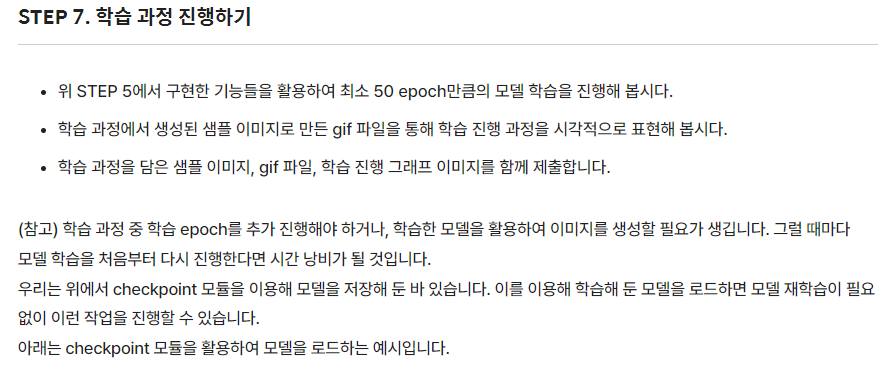

In [345]:
save_every = 5
EPOCHS = 50 #100
#에폭을 더 늘려야할거같다...
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

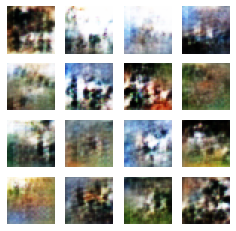

Time for training : 1519 sec


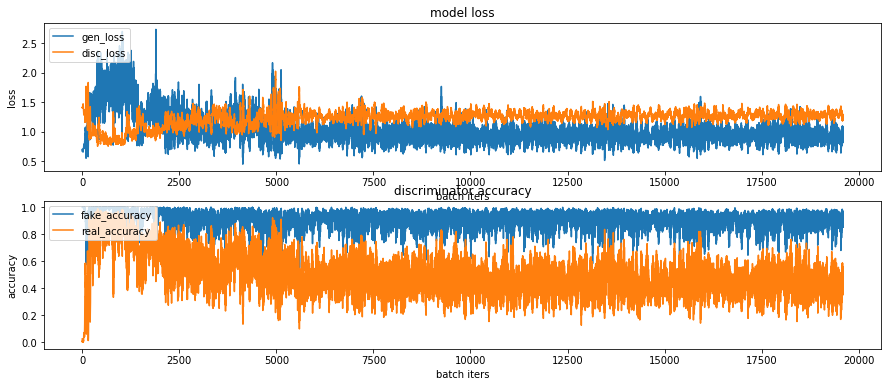

CPU times: user 26min 3s, sys: 2min 5s, total: 28min 9s
Wall time: 25min 21s


In [312]:
%%time
train(train_dataset, EPOCHS,save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

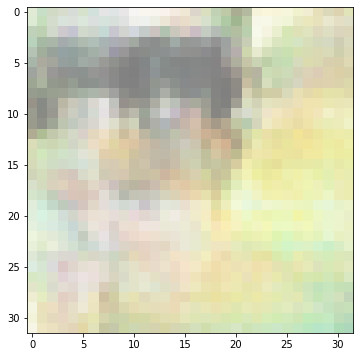

In [346]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 미지가 그려CIFAR-10 이질 것입니다.

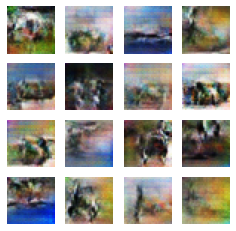

Time for training : 740 sec


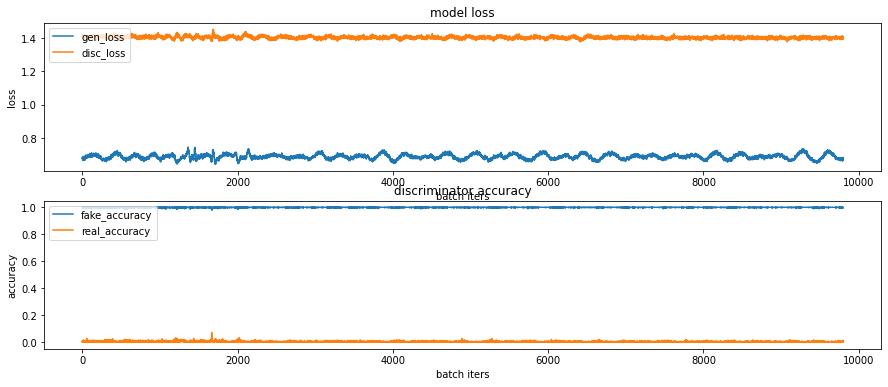

CPU times: user 12min 48s, sys: 1min 3s, total: 13min 52s
Wall time: 12min 21s


In [347]:
%%time
train(train_dataset, EPOCHS, save_every)
#checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

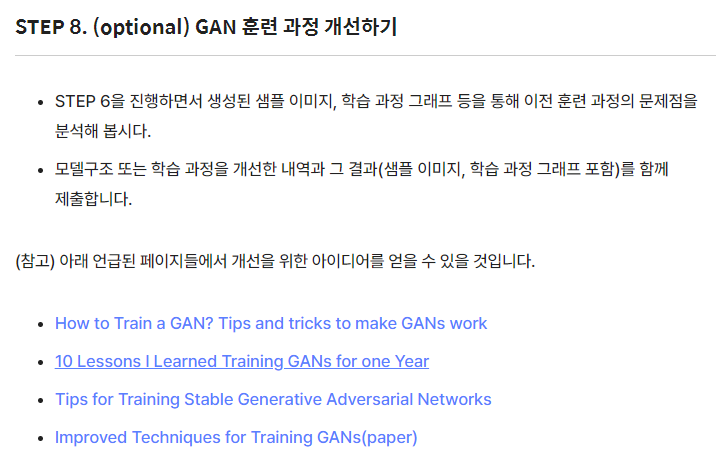

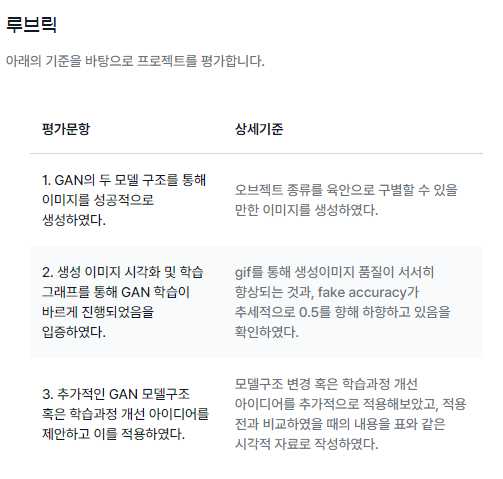

### 이미지데이터셋을 -1,1범위로 정규화한후 모델의 수정(하이퍼파라미터,드롭아웃규제, 라벨스무딩,학습률스케쥴러등)전의 형태
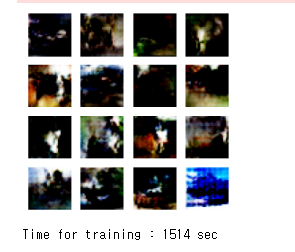
### 이미지데이터셋을 판별자의 학습률 조정빼고 나머지를 조정했을때
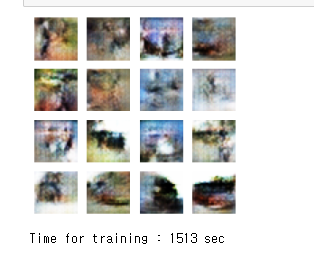
### 판별자의 fake acc를 낮추기위해 학습빈도수를 생성자의 반으로 줄였을때(오히려 fake acc가 너무 위아래로 튀고 판별자의 성능이 너무 저하되서 생성을 잘 못함..)
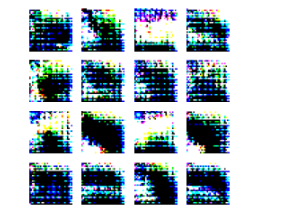

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

In [ ]:
# 라벨 스무딩 (Label Smoothing):
# 라벨 스무딩은 라벨을 0과 1로 고정시키는 대신, 조금 더 부드러운 값, 예를 들어 0.1이나 0.9와 같은 값으로 대체하는 기법입니다. 이는 판별자가 너무 확실하게 판단하지 못하게 하여 과적합을 방지합니다.
# smooth = 0.1
# real_labels = tf.ones((batch_size, 1)) * (1 - smooth)
# fake_labels = tf.zeros((batch_size, 1)) + smooth

# # 판별자 손실 계산 시 라벨 스무딩 적용
# with tf.GradientTape() as disc_tape:
#     real_output = discriminator(real_images, training=True)
#     fake_output = discriminator(generated_images, training=True)
#     disc_loss = discriminator_loss(real_output, real_labels) + \
#                 discriminator_loss(fake_output, fake_labels)


### 모델성능향상을 위해 추가적으로 적용해본것
- 판별자네트워크의 드롭아웃 규제를 0.3->0.5로 상승(판별자가 너무 판별성능이 뛰어나서 생성자가 업데이트가 잘 안되는거 같았기때문)
- 학습이미지셋을 고화질의 더좋은 이미지를 구해보기(쉽지않고, 컴퓨터의 성능이 못따라가는 문제로인해 pass)
- 모델의 층을 깊게 쌓아보자(해상도를 높이고 모델의 층을 깊게쌓아보았지만 실패)
- 판별자의optimizer의 학습률 조정(학습률 스케줄링 (Learning Rate Scheduling):학습률 스케줄링은 학습 과정 중에 학습률을 조절하는 기법입니다. 예를 들어, 학습이 진행됨에 따라 학습률을 점진적으로 감소시킬 수 있습니다.)
- 총 학습시킨epochs:100+100+100+100
- 라벨스무딩을 적용하여 판별자를 좀더 유연하게 학습시키기위해,판별자의 성능을 살짝 낮추기위해 사용
- 데이터전처리를 -1,1이아닌 0,1로 바꾼후 판별자 출력함수를 sigmoid로 변경
- 판별자의 fake acc아직 너무 높기때문에 판별자의 성능을 낮추기위해 생성자보다 학습빈도를 낮추는 방법시도(생성자2번학습시 판별자 학습1번)

## 회고 및 앞으로 시도해볼것
-  k:처음에는 아예 이미지도아닌 노이즈만 잔뜩있는 이미지였으나 점점 발전하는것이 보여서 포기하지않고 이미지가 보다 잘 생성될수있게 다양한 방법들을 시도해보았다.
- p:논문이나 구글링시 DCGAN의 성능을 높여 판별자의 fake acc를 낮추는 방법들을 많이시도하는과정에서 오류가 많았다. 특히 모델의 구조를 깊게쌓으면 더많은 이미지의 feature의 학습을 하고 더 잘 생성할거같았지만 shape에러를 수정하면서 시도했을때는 별다른 변화가 없었던거같다. 그리고 fake  acc가 계속 1에서 안떨어지는(판별자모델의 성능이 너무 뛰어나게 학습되서 생성자모델이 경쟁을 못함)되는 문제는 아직 해결된거같지않다. 데이터의 픽셀값을  -1,1로 정규화하여 출력층에 tanh함수를 사용하는방법이 성능을 높이고 이미지생성의 성능향상이된다고했지만 실제로 이미지가 너무 어둡게 보이는부분들이 많았고  0,1로 정규화후  sigmoid함수를 사용하는것이 더 잘 생성되는거 같은 느낌이었다. 생성자보다 판별자의 학습이 뛰어난거같아 학습빈도도 비교하면서 줄여보았지만 오히려 적절한 값을 찾지 못해서인지 이미지생성자체가 거의 안되는 문제가 발생했다(경쟁을 아예못하고 판별자의 fake acc가 위아래고 너무튀었다), 그리고 생성된 이미지들중 비슷한 배경이나 색감등 학습을 너무 많이해서 학습데이터에 과적합된거같은 문제가 보였다.
- t: 향후 다시 tanh함수를 사용하여 시도해보거나 시간이 없어서 하지못했던 fake acc를 낮추는 방법을 시도해보아야겠다.(학습률스케줄링을 통해 조절해보거나 모델의 구조를 변화시켜보기,dcgan말고 GAN(예: WGAN, LSGAN 등)